In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit,transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit import BasicAer
import numpy as np
import pandas as pd
from collections import Counter
# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

# Multiple throw/day simulation in one time

In [2]:
###### Estimting number of Qubits required ###########

N = 4  # number of balls and number of buckets 
n = len(format(N-1,'b')) # number of qubits per ball/bucket

print(N*n,"qubits required")

8 qubits required


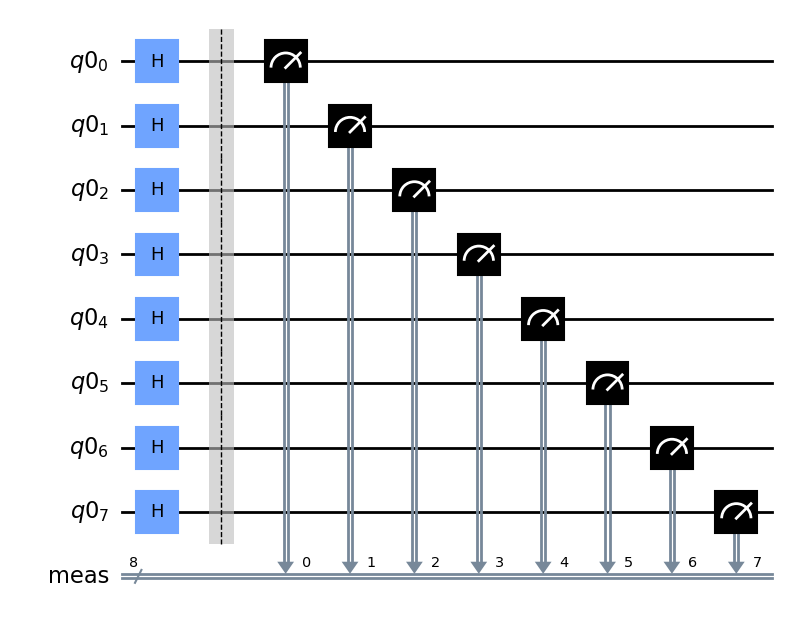

In [3]:
########### Building the Game #############

qreg = QuantumRegister(N*n)
circuit = QuantumCircuit(qreg)


circuit.h(range(len(qreg)))
circuit.measure_all()
circuit.draw('mpl')

In [131]:
########## Simulating 1 throw ##########
d = 10 # number of throws/days

backend = BasicAer.get_backend('qasm_simulator') # the device to run on
result = backend.run(transpile(circuit, backend), shots=d).result()
counts  = result.get_counts()

print("Result of throws: ",counts)

Result of throws:  {'110110101011000000100111': 1, '001000011000110000100000': 1, '100000000000011110010110': 1, '001110101110000101011110': 1, '011010110101010010010101': 1, '100100010111110001101110': 1, '010001110001000011101110': 1, '000110101111011101101101': 1, '000100100000011100111111': 1, '110011110011000101010110': 1}


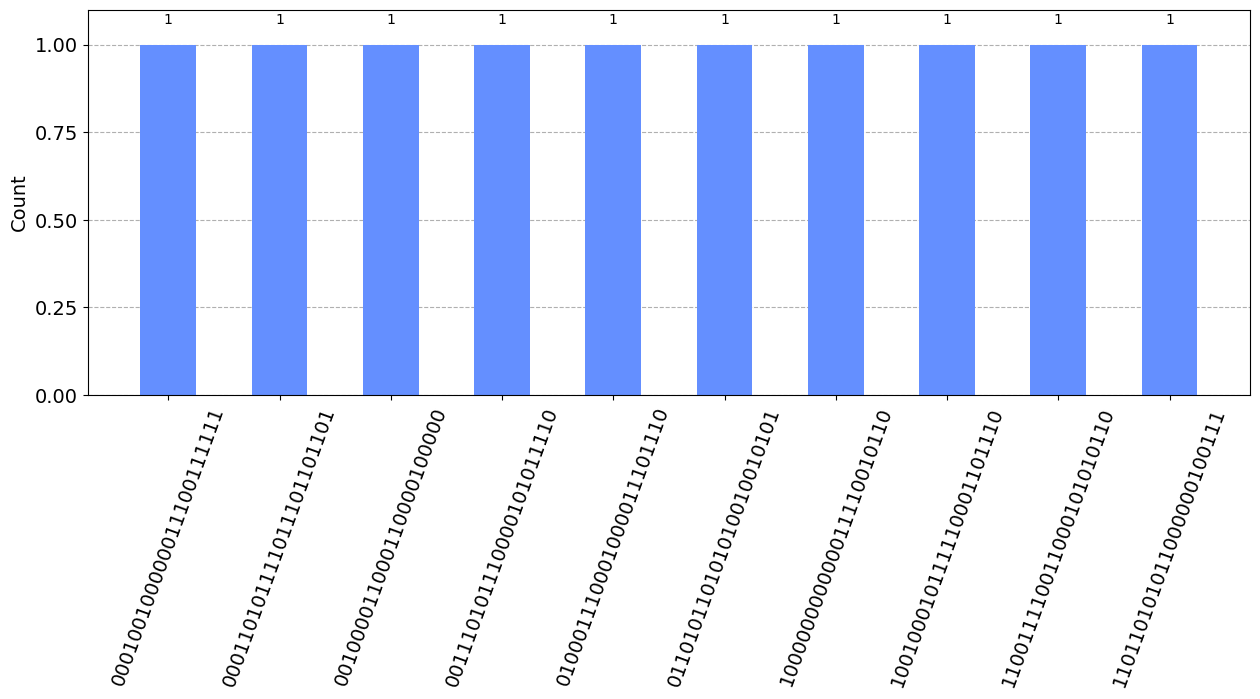

In [132]:
plot_histogram(counts,figsize=(15,5))

In [133]:
# b = np.array([int(config[i:i+2],2) for i in range(0,len(config),n)])

In [134]:
#################  Converting the result into bucket/restaurant number ###############

COUNTS = {}
for k,v in counts.items():
    config = [str(int(k[i:i+n],2)) for i in range(0,len(k),n)]
    key = "".join([str(item) for item in config])
    COUNTS[key] = v

    
print("The bucket-ball config:",COUNTS)    

The bucket-ball config: {'66530047': 1, '10306040': 1, '40003626': 1, '16560536': 1, '32652225': 1, '44276156': 1, '21610356': 1, '06573555': 1, '04403477': 1, '63630526': 1}


### Interpretation of one sample eigenstate (count started from 0)
one of the configuration is '|22361>'. what it means? 
* 1st ball went to 3rd bucket 
* 2nd ball also went to 3rd bucket - As 1st ball is already in the 3rd bucket, hence 2nd ball is lost
* 3rd ball went to 4th bucket
* 4th ball went to 7th bucket - Invlid config, as 5 buckets are available
* 5th ball went to 2nd bucket
* No ball has fallen into 0,4,5,7 th bucket \
position = ball number (from left) \
number = bucket number

In [135]:
##################### Removing outputs with unused buckets ############

buckets = np.arange(2**n)
unused_buckets = list((buckets[buckets > (N-1)]).astype(str)) #['5','6','7']

filtered_counts = {}

for k,v in COUNTS.items():
    if not any([x in k for x in unused_buckets]):
        filtered_counts[k] = v
    else:
        # print("Rejecting {} as it's a invlid bucket set".format(k))
        pass
    
print("Filtered ball-bucket combinations:",filtered_counts)

Filtered ball-bucket combinations: {'66530047': 1, '10306040': 1, '40003626': 1, '16560536': 1, '32652225': 1, '44276156': 1, '21610356': 1, '06573555': 1, '04403477': 1, '63630526': 1}


In [136]:
############### Removing balls from same buckets #################

final_output = {}

for k,v in filtered_counts.items():
    t = [i for i in k]
    counter = dict(Counter(k))
    uniques = list(counter.keys())
    k_array = np.array([int(i) for i in k])
    
    for u in uniques:
        locations = np.where(k_array == int(u))
        indices = locations[0][1:]
        if len(indices) >= 1:
            for j in indices:
                t[j] = 'X'
                # print('Replacing {} with X for {}'.format(j,u))
        else:
            pass
    final_output[''.join(t)] = v 
    # print(k,''.join(t))
        

print("The final output:",final_output)

The final output {'6X530X47': 1, '103X6X4X': 1, '40XX362X': 1, '165X0X3X': 1, '3265XXXX': 1, '4X27615X': 1, '216X035X': 1, '06573XXX': 1, '04XX3X7X': 1, '63XX052X': 1}


In [137]:
########### Calculating the average occupancy ################

occupancy = 0
valid_trials = 0 
for k,v in final_output.items():
    occupancy += ((len(k) - k.count('X'))/len(k))*v
    valid_trials += v

print('The average occupancy is:', occupancy*100/valid_trials,'%')

The average occupancy is: 63.75 %


In [138]:
valid_trials

10